# Assignment 3: Integer Programming Example---Algorithmic Redistricting

In [69]:
# imports
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, LpBinary
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import random

# Define the adjacency list for Washington state
adjacency_list = {
    "Adams County": ["Franklin County", "Grant County", "Lincoln County", "Whitman County"],
    "Asotin County": ["Nez Perce County, ID", "Wallowa County, OR", "Garfield County", "Whitman County"],
    "Benton County": ["Morrow County, OR", "Umatilla County, OR", "Franklin County", "Grant County", "Klickitat County", "Walla Walla County", "Yakima County"],
    "Chelan County": ["Douglas County", "King County", "Kittitas County", "Okanogan County", "Skagit County", "Snohomish County"],
    "Clallam County": ["Jefferson County", "San Juan County"],
    "Clark County": ["Columbia County, OR", "Multnomah County, OR", "Cowlitz County", "Skamania County"],
    "Columbia County": ["Umatilla County, OR", "Wallowa County, OR", "Franklin County", "Garfield County", "Walla Walla County", "Whitman County"],
    "Cowlitz County": ["Columbia County, OR", "Clark County", "Lewis County", "Skamania County", "Wahkiakum County"],
    "Douglas County": ["Chelan County", "Grant County", "Kittitas County", "Okanogan County"],
    "Ferry County": ["Lincoln County", "Okanogan County", "Stevens County"],
    "Franklin County": ["Adams County", "Benton County", "Columbia County", "Grant County", "Walla Walla County", "Whitman County"],
    "Garfield County": ["Wallowa County, OR", "Asotin County", "Columbia County", "Whitman County"],
    "Grant County": ["Adams County", "Benton County", "Douglas County", "Franklin County", "Kittitas County", "Lincoln County", "Okanogan County", "Yakima County"],
    "Grays Harbor County": ["Jefferson County", "Lewis County", "Mason County", "Pacific County", "Thurston County"],
    "Island County": ["Jefferson County", "Kitsap County", "San Juan County", "Skagit County", "Snohomish County"],
    "Jefferson County": ["Clallam County", "Grays Harbor County", "Island County", "Kitsap County", "Mason County", "San Juan County"],
    "King County": ["Chelan County", "Kitsap County", "Kittitas County", "Pierce County", "Snohomish County", "Yakima County"],
    "Kitsap County": ["Island County", "Jefferson County", "King County", "Mason County", "Pierce County", "Snohomish County"],
    "Kittitas County": ["Chelan County", "Douglas County", "Grant County", "King County", "Pierce County", "Yakima County"],
    "Klickitat County": ["Gilliam County, OR", "Hood River County, OR", "Morrow County, OR", "Sherman County, OR", "Wasco County, OR", "Benton County", "Skamania County", "Yakima County"],
    "Lewis County": ["Cowlitz County", "Grays Harbor County", "Mason County", "Pacific County", "Thurston County"],
    "Lincoln County": ["Adams County", "Douglas County", "Ferry County", "Grant County", "Okanogan County"],
    "Mason County": ["Grays Harbor County", "Jefferson County", "Kitsap County", "Pierce County", "Thurston County"],
    "Okanogan County": ["Chelan County", "Douglas County", "Ferry County", "Grant County", "Stevens County"],
    "Pacific County": ["Grays Harbor County", "Lewis County", "Skamania County"],
    "Pierce County": ["King County", "Kitsap County", "Lewis County", "Mason County", "Skagit County", "Thurston County"],
    "San Juan County": ["Island County", "Jefferson County"],
    "Skagit County": ["Chelan County", "Island County", "Pierce County", "Snohomish County"],
    "Skamania County": ["Clark County", "Cowlitz County", "Klickitat County", "Pacific County"],
    "Snohomish County": ["Chelan County", "Island County", "King County", "Kitsap County", "Skagit County"],
    "Spokane County": ["Adams County", "Lincoln County", "Whitman County"],
    "Stevens County": ["Ferry County", "Okanogan County"],
    "Thurston County": ["Grays Harbor County", "Lewis County", "Mason County", "Pierce County"],
    "Walla Walla County": ["Benton County", "Columbia County", "Franklin County"],
    "Whatcom County": ["Skagit County"],
    "Whitman County": ["Adams County", "Asotin County", "Columbia County", "Franklin County", "Garfield County", "Spokane County"],
    "Yakima County": ["Benton County", "Grant County", "King County", "Kittitas County", "Klickitat County"]
}

# Load population data
file_path = '/content/drive/My Drive/MSDS 460/table-data.csv'
pop_data = pd.read_csv(file_path)
county_population = pop_data.set_index('county')['pop2024'].to_dict()
total_population = sum(county_population.values())
num_districts = 10
ideal_population = total_population / num_districts


# Create the Optimization Problem
- Set partitioning.

- Population balance.

- Compact districts.

In [70]:
# Create the optimization problem
prob = LpProblem("Washington_State_Redistricting", LpMinimize)

# Decision variables: binary variable for each county-district assignment
county_district_vars = {
    (county, district): LpVariable(f"assign_{county}_{district}", 0, 1, cat='Binary')
    for county in county_population.keys()
    for district in range(1, num_districts + 1)
}

# Objective: minimize the sum of absolute population differences
pop_balance_vars = {
    district: LpVariable(f"pop_balance_{district}", lowBound=0)
    for district in range(1, num_districts + 1)
}

# Constraint: Each county assigned to exactly one district
for county in county_population.keys():
    prob += lpSum(county_district_vars[(county, district)] for district in range(1, num_districts + 1)) == 1

# Population balance constraint
for district in range(1, num_districts + 1):
    district_population = lpSum(county_district_vars[(county, district)] * county_population[county] for county in county_population.keys())
    prob += district_population - ideal_population <= pop_balance_vars[district]
    prob += ideal_population - district_population <= pop_balance_vars[district]

# Adjacency constraint
for county, neighbors in adjacency_list.items():
    for district in range(1, num_districts + 1):
        prob += county_district_vars[(county, district)] <= lpSum(county_district_vars[(neighbor, district)] for neighbor in neighbors if neighbor in county_population)

# Ensure each district has at least one county assigned
for district in range(1, num_districts + 1):
    prob += lpSum(county_district_vars[(county, district)] for county in county_population.keys()) >= 2

# Solve the problem
prob.solve()

1

In [71]:
# Display the status
print("Status:", LpStatus[prob.status])

# Save the district assignments
districts = {i: [] for i in range(1, num_districts + 1)}
district_populations = {i: 0 for i in range(1, num_districts + 1)}

for county, district in county_district_vars:
    if county_district_vars[(county, district)].varValue == 1:
        districts[district].append(county)
        district_populations[district] += county_population[county]

# Output district assignments and populations
print("District assignments and populations:")
for district, counties in districts.items():
    print(f"District {district}: {counties}, Population: {district_populations[district]}")


Status: Optimal
District assignments and populations:
District 1: ['Snohomish County', 'Spokane County', 'Thurston County', 'Yakima County', 'Whatcom County', 'Skagit County', 'Grant County', 'Lewis County', 'Mason County', 'Kittitas County', 'Okanogan County', 'Asotin County', 'Lincoln County', 'Garfield County'], Population: 2708612
District 2: ['Benton County', 'Walla Walla County', 'Columbia County'], Population: 282972
District 3: ['Kitsap County', 'Jefferson County'], Population: 311361
District 4: ['Franklin County', 'Whitman County', 'Adams County'], Population: 168673
District 5: ['King County', 'Pierce County'], Population: 3208362
District 6: ['Grays Harbor County', 'Pacific County'], Population: 101844
District 7: ['Clark County', 'Cowlitz County', 'Chelan County', 'Douglas County', 'Pend Oreille County', 'Wahkiakum County'], Population: 783982
District 8: ['Klickitat County', 'Skamania County'], Population: 36700
District 9: ['Stevens County', 'Ferry County'], Population: 

Test to see if all counties in a district are adjacent.

In [72]:
def check_adjacency(districts, adjacency_list):
    adjacency_results = {}
    for d, counties in districts.items():
        are_adjacent = True
        for county in counties:
            neighbors = adjacency_list.get(county, [])
            if not any(neighbor in counties for neighbor in neighbors):
                are_adjacent = False
                break
        adjacency_results[d] = are_adjacent
    return adjacency_results

# Check adjacency
adjacency_results = check_adjacency(districts, adjacency_list)

# Output adjacency results
for d, result in adjacency_results.items():
    print(f"District {d}: {'All counties are adjacent' if result else 'Counties are not all adjacent'}")


District 1: All counties are adjacent
District 2: All counties are adjacent
District 3: All counties are adjacent
District 4: All counties are adjacent
District 5: All counties are adjacent
District 6: All counties are adjacent
District 7: Counties are not all adjacent
District 8: All counties are adjacent
District 9: All counties are adjacent
District 10: All counties are adjacent


Create a Map of the Redistribution in Washington

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-73-15e9343b45d0>:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this ope

              NAME  district
606       Columbia         2
607       Franklin         4
626          Lewis         1
627          Mason         1
628        Stevens         9
1739         Adams         4
1740        Asotin         1
1741        Benton         2
1742       Cowlitz         7
1743       Douglas         7
1744         Ferry         9
1745      Garfield         1
1746         Grant         1
1788        Island        10
1835      Kittitas         1
1836     Klickitat         8
1837      Skamania         8
1838       Whitman         4
2401         Clark         7
2402        Kitsap         3
2475          King         5
2493       Lincoln         1
2494  Pend Oreille         7
2495        Pierce         5
2534       Spokane         1
2535      Thurston         1
2536     Wahkiakum         7
2537        Yakima         1
3051        Chelan         7
3083      Okanogan         1
3093     Jefferson         3
3096       Pacific         6
3106      San Juan        10
3107     Snoho

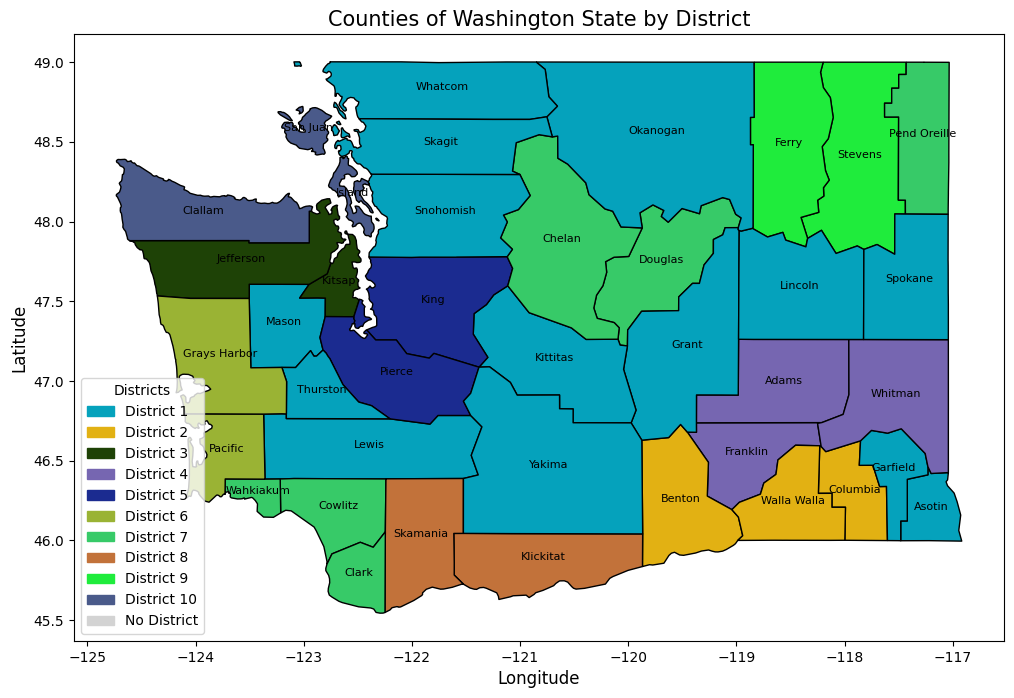

In [73]:
# GeoJSON URL for the counties
geojson_url = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'

# Load the GeoJSON data into a GeoDataFrame
counties = gpd.read_file(geojson_url)

# Filter for Washington State
washington_counties = counties[counties['STATE'] == '53']


# Create a color mapping for districts
colors = {district: f'#{random.randint(0, 0xFFFFFF):06x}' for district in districts.keys()}

# Add a column for the district assignment based on county names
washington_counties['district'] = 0
for district, counties_list in districts.items():
    for county in counties_list:
        matching_county = washington_counties['NAME'].str.contains(county.split()[0], case=False, na=False)
        washington_counties.loc[matching_county, 'district'] = district

# Debug: Print out the mapping to verify correct assignment
print(washington_counties[['NAME', 'district']])

# Assign colors based on district assignments
washington_counties['color'] = washington_counties['district'].map(colors).fillna('lightgrey')

print(washington_counties[['NAME', 'district', 'color']])

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the counties with assigned colors
washington_counties.plot(ax=ax, edgecolor='black', facecolor=washington_counties['color'])

# Add county names as labels
for x, y, label in zip(washington_counties.geometry.centroid.x,
                        washington_counties.geometry.centroid.y,
                        washington_counties['NAME']):
    ax.text(x, y, label, fontsize=8, ha='center')

# Create a legend
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[district]) for district in districts]
handles.append(plt.Rectangle((0, 0), 1, 1, color='lightgrey'))  # For counties without a district
ax.legend(handles, [f'District {district}' for district in districts] + ['No District'], title="Districts", loc='lower left')

# Create title and labels
ax.set_title('Counties of Washington State by District', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Show the plot
plt.show()


Check that all counties (39) in Washington are accounted for each district

In [74]:
assigned_counties = set()

for d in districts:
    assigned_counties.update(districts[d])

# Get the unique counties and count
unique_counties_count = len(assigned_counties)

print(f"Unique counties assigned across all districts: {unique_counties_count}")
print(f"Counties: {', '.join(assigned_counties)}")

Unique counties assigned across all districts: 39
Counties: Okanogan County, Lincoln County, Spokane County, Wahkiakum County, Garfield County, Jefferson County, Skamania County, Douglas County, Franklin County, Ferry County, Mason County, Grays Harbor County, Columbia County, Walla Walla County, Chelan County, Grant County, Whitman County, Clark County, King County, Clallam County, Snohomish County, Cowlitz County, Benton County, Kitsap County, San Juan County, Pierce County, Klickitat County, Skagit County, Lewis County, Whatcom County, Pacific County, Kittitas County, Thurston County, Stevens County, Asotin County, Yakima County, Adams County, Pend Oreille County, Island County
